In [14]:
from collections import defaultdict
import pandas as pd
import numpy as np
import timesfm
import multiprocessing

import torch
import torch.nn.functional as F
import argparse
import os
import time
import math
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.itertools import batcher
from utils.utils import load_test_data
from utils.data_loader import create_cached_tsmixup_datasets
from load_cached_features import *
from timesfm.pytorch_patched_decoder import ResidualBlock
import matplotlib.pyplot as plt
# from utils.utils import load_test_data
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 33  # batch size: any positive integer
TEST = 100  # test set length: any positive integer
context_len = 512
pred_len = 128
device = 'cuda:3'

In [2]:
tfm = timesfm.TimesFm(
            hparams=timesfm.TimesFmHparams(
                backend='gpu',
                per_core_batch_size=64,
                context_len=context_len,  # currently max supported
                horizon_len=pred_len,  # number of steps to predict
                input_patch_len=32,  # fixed parameters
                output_patch_len=128,
                num_layers=50,
                model_dims=1280,
                use_positional_embedding=False,
                point_forecast_mode='mean',
                device=device,
            ),
            checkpoint=timesfm.TimesFmCheckpoint(
                huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
        )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
# Loading tsmixup dataset
train_dataset, val_dataset = create_cached_tsmixup_datasets(
        max_samples=300000,
        context_length=512,
        prediction_length=96, # 1 or 96
        num_workers=16,
        cache_dir="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/",
        processed_cache_path="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_96.pkl",
        batch_size=4000
    )

def load_dataset(dataset, ts=1000, pred_length=1, ctx_len=512):
    if dataset == 'tsmixup':
        x = []
        y = []
        for i in range(ts) if isinstance(ts, int) else ts:
            val_dict = val_dataset[i]
            x.append(val_dict['past_values'])
            y.append(val_dict['future_values'])
        x = torch.stack(x)[:, -ctx_len:]
        y = torch.stack(y)[:,:pred_length]
        
    else:
        dataset_path = f"/extra/datalab_scratch0/ctadler/time_series_models/ts_foundation_calibration/data/{dataset}/y_{dataset}.csv"
        timestamp_column = "ds"

        data = pd.read_csv(
            dataset_path,
            parse_dates=[timestamp_column],
            index_col=0
        )

        x = []
        for id, vals in data.groupby('unique_id'):
            x.append(torch.from_numpy(vals['y'].to_numpy(np.float32)))
        x = torch.stack(x)

    if dataset != 'tsmixup':
        y = x[:,ctx_len:ctx_len+pred_length]
        x = x[:,:ctx_len]
    return x, y

🚀 CREATING CACHED TSMIXUP DATASETS
📂 Found existing processed data at /extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_96.pkl
⚡ Loading preprocessed data from cache...
✅ Loaded 174,209 preprocessed samples
📅 Cache created: 2025-08-03 15:05:17

📊 DATASET SUMMARY:
  Total processed samples: 174,209
  Context length: 512
  Prediction length: 96
🔀 Shuffling data...
📈 Data split:
  Training samples: 156,788
  Validation samples: 17,421
  Train ratio: 90.0%
🏗️  Creating PyTorch datasets...
🏗️  Dataset created with 156,788 samples
📊 Augmentation: ON
📈 Dataset Statistics (from 1000 samples):
  Sequence lengths: min=608, max=2043, mean=1320
  Value ranges: min=-49.2103, max=70.9532
  Value stats: mean=0.9038, std=2.2952
🏗️  Dataset created with 17,421 samples
📊 Augmentation: OFF
📈 Dataset Statistics (from 1000 samples):
  Sequence lengths: min=608, max=2048, mean=1284
  Value ranges: min=-28.6077, max=79.0030
  Value

In [4]:
def run_model(test_data, quantiles, PDT, unit, freq, freq_delta, save_dir, CTX, tfm=None):
    freq_id = {"M":1, "W":1, "D":0, "h":0, "min":0, "s":0, 'T':0, 'S':0, 'H':0}[unit]

    # Load Model
    if tfm == None:
        tfm = timesfm.TimesFm(
            hparams=timesfm.TimesFmHparams(
                backend='gpu',
                per_core_batch_size=32,
                context_len=CTX,  # currently max supported
                horizon_len=PDT,  # number of steps to predict
                input_patch_len=32,  # fixed parameters
                output_patch_len=128,
                num_layers=50,
                model_dims=1280,
                use_positional_embedding=False,
                point_forecast_mode='mean',
                device=device
            ),
            checkpoint=timesfm.TimesFmCheckpoint(
                huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
        )

    mean_results = []
    median_results = []
    quantile_results = [[] for _ in quantiles]
    start_time = time.time()
    id = -1
    for batch in batcher(test_data.input, batch_size=BSZ):
        context = [torch.tensor(entry["target"]) for entry in batch]
        _, quantile_forecasts = tfm.forecast(context,
                                            freq=[freq_id] * len(context))
        for entry, forecasts in zip(batch, quantile_forecasts):
            if id != entry["item_id"]:
                id = entry["item_id"]
                print(f"Run Time: {time.time()-start_time:.2f}, ID: {id}")
            start_date = entry["start"] + (len(entry["target"])-1)
            mean_results.append([id, start_date, *forecasts[:,0]])
            median_results.append([id, start_date, *forecasts[:,5]])
            for i in range(len(quantiles)):
                quantile_results[i].append([id, start_date, *forecasts[:,quantiles[i]//10]])

    print(f'done: {time.time()-start_time:.2f}')

    # os.makedirs(save_dir, exist_ok=True)
    # columns = ['unique_id', 'ds', *range(1,PDT+1)]
    # mean_results = pd.DataFrame(mean_results, columns=columns)
    # mean_results.to_csv(f"{save_dir}/mean_preds.csv")
    # median_results = pd.DataFrame(median_results, columns=columns)
    # median_results.to_csv(f"{save_dir}/median_preds.csv")
    # for i, quantile in enumerate(quantiles):
    #     quantile_result = pd.DataFrame(quantile_results[i], columns=columns)
    #     quantile_results[i] = quantile_result
    #     quantile_result.to_csv(f"{save_dir}/quantile_{quantile}_preds.csv")

    
# dataset = "amazon-google"
# test_data, freq, unit, freq_delta = load_test_data(pred_len, context_len, None, f"/extra/datalab_scratch0/ctadler/time_series_models/ts_foundation_calibration/data/{dataset}/y_{dataset}.csv", "")
# run_model(test_data, range(10), pred_len, unit, freq, freq_delta, None, context_len, tfm=tfm)

In [5]:
@torch.no_grad()
def process_transformer_output(model: timesfm.TimesFm, stats, model_output, output_patch_len, output_dim):
    output_ts = model._model.horizon_ff_layer(model_output)

    # Reshape using view
    b, n, _ = output_ts.shape
    output_ts = output_ts.view(b, n, output_patch_len, output_dim)

    mu = stats[..., 0]
    sigma = stats[..., 1]
    output_ts = output_ts * sigma[:, None, None, None] + mu[:, None, None, None]
    return output_ts[:, -1].numpy()
    # return model.ppd._reverse_transform(output_ts, stats)

x, y = load_dataset('tsmixup', 100, pred_length=pred_len, ctx_len=context_len)
# print(x.shape)
batch_size = 64
context = [x[i] for i in range(batch_size)]
# print(context)
# print(len(context), context[0].shape)
_, quantile_forecasts, (transformer_output, stats) = tfm.forecast(context, freq=[0] * len(context), get_stacked_transformer=True)
pred_quants = process_transformer_output(tfm, stats, transformer_output, 128, 10)
print(f"quantile shape: {quantile_forecasts.shape}, pred_quants: {pred_quants.shape}, mse: {np.sum(quantile_forecasts - pred_quants)}")
print(transformer_output.shape, stats.shape)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:4 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
transformer_output = transformer_output.to(torch.float16)
print(f"{(transformer_output[0].nelement() * transformer_output[0].element_size() / 1e9 * len(train_dataset) * 23000/680):.2f} GB")

217.22 GB


In [3]:
full_ds = FullLatentShardDataset("./data/timesfm_cache_full_fp16/full_shard_*.pt")

In [ ]:
batch_size = 512
latents, stats, labels = [], [], []
start_time = time.time()
for i in range(batch_size):
    latent, stat, label = full_ds[i]
    latents.append(latent)
    stats.append(stat)
    labels.append(label)
latents = torch.stack(latents).to(device)
stats = torch.stack(stats).to(device)
labels = torch.stack(labels).to(device)
print(f"Loaded batch in {time.time()-start_time:.3f} seconds")
start_time = time.time()
print(latents.shape, stats.shape, labels.shape)
pred_quants = reconstruct_quantiles_from_full(latents, stats, tfm._model.horizon_ff_layer, 128, 10, device=device)
print(pred_quants.shape)

NameError: name 'batch_size' is not defined

In [22]:
# Gaussian Prediction Head
patch_len = 32
hidden_size = 1280
intermediate_size = 1280
output_dims = 1
horizon_len = 96
tot_iters = 524288
batch_size = 512
pred_head = ResidualBlock(
        input_dims=hidden_size,
        output_dims=horizon_len*output_dims,
        hidden_dims=intermediate_size,
    ).to(device).train()

# pred_head = torch.nn.Linear(hidden_size, horizon_len*output_dims).to(device).train()

# loss_fn = torch.nn.GaussianNLLLoss(eps=1e-6)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(pred_head.parameters(), lr=3e-4, weight_decay=1e-2)
grad_clip = 1.0
scaler = torch.amp.GradScaler()

logvar_min, logvar_max = -10.0, 10.0              # normalized log-variance bounds
sigma_floor, sigma_ceiling = 1e-6, 1e6            # per-sample sigma bounds in original units
var_floor, var_ceiling = 1e-12, 1e12              # final variance bounds
min_std_norm = 0.05                               # floor on normalized std (pre sigma scaling)

training_loss = []
tfm_loss = []

In [24]:
# Training setup
loss_batch = []
tfm_loss_batch = []
for epoch in range(3):
    for batch_num in range(0, tot_iters, batch_size):
        latents, stats, labels = [], [], []
        for i in range(batch_size):
            dataset_ind = batch_num + i
            latent, stat, label = full_ds[dataset_ind]
            latents.append(latent)
            stats.append(stat)
            labels.append(label)
        latents = torch.stack(latents)[:,-1].to(device).float()
        stats   = torch.stack(stats).to(device)
        labels  = torch.stack(labels).to(device)
        nan_mask = (~torch.isfinite(latents))
        latents_max, _ = latents.max(dim=1)
        quantile_mask = latents_max > torch.quantile(latents_max, 0.99)
        # print(nan_mask.float().mean())
        nan_mask = torch.any(nan_mask, dim=1) | quantile_mask
        # print(nan_mask)

        if torch.any(nan_mask != 0):
            latents = latents[~nan_mask]
            stats = stats[~nan_mask]
            labels = labels[~nan_mask]
            # print(f"nan in latents. new shape: latents {latents.shape}, stats: {stats.shape}, labels: {labels.shape}")
        if stats.isnan().any():
            print(f"stats is nan")
        if labels.isnan().any():
            print(f"labels is nan")

        optimizer.zero_grad(set_to_none=True)
        out = pred_head(latents)  # [B, horizon_len * output_dims]
        b, _ = out.shape
        out = out.view(b, horizon_len, output_dims)  # [B, H, D]

        mu    = stats[:, 0].float()                                # [B]
        sigma = stats[:, 1].float()
        mu_pred = out[:, :, 0]
        y = (labels.float() - mu[:, None]) / sigma[:, None]             # [B, H]
        loss = loss_fn(mu_pred, y)
        loss_batch.append(loss.item())

        # Backward with AMP
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(pred_head.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()


        with torch.no_grad():            
            output_ts = tfm._model.horizon_ff_layer(latents)
            b, _ = output_ts.shape
            output_ts = output_ts.view(b, 128, 10)[:, :horizon_len, 0]
            tfm_loss_batch.append(F.mse_loss(output_ts, y).item())
        # print(f"isfinite: latents {torch.isfinite(latents).all()} count: {torch.count_nonzero(torch.logical_not(torch.isfinite(latents)))}")
        # print(f"isfinite: mu_pred {torch.isfinite(mu_pred).all()}, min {mu_pred.min():.2e} max {mu_pred.max():.2e} q(0.999) {torch.quantile(mu_pred, 0.999):.2e}")
        # print(f"isfinite: y {torch.isfinite(y).all()}, min {y.min():.2e} max {y.max():.2e} q(0.999) {torch.quantile(y, 0.999):.2e}")
        # print(f"isfinite: labels {torch.isfinite(labels).all()}, min {labels.min():.2e} max {labels.max():.2e} q(0.999) {torch.quantile(labels, 0.999):.2e}")
        # print(f"isfinite: sigma {torch.isfinite(sigma).all()}, min {sigma.min():.2e} max {sigma.max():.2e} q(0.999) {torch.quantile(sigma, 0.999):.2e}")
        # Logging
        if batch_num % (batch_size * 10) == 0:
            train_med_loss = np.median(np.array(loss_batch))
            tfm_med_loss = np.median(np.array(tfm_loss_batch))
            loss_batch = []
            tfm_loss_batch = []
            print(f"epoch: {epoch} batch_num: {batch_num // batch_size} loss: {train_med_loss:.4f}")
            print(f"TimesFM mse: {tfm_med_loss:.4f}")
            training_loss.append(train_med_loss)
            tfm_loss.append(tfm_med_loss)

epoch: 0 batch_num: 0 loss: 96.3722
TimesFM mse: 56.2845
epoch: 0 batch_num: 10 loss: 161.0272
TimesFM mse: 110.5982
epoch: 0 batch_num: 20 loss: 259.3527
TimesFM mse: 195.9392
epoch: 0 batch_num: 30 loss: 104.2952
TimesFM mse: 112.7461
epoch: 0 batch_num: 40 loss: 177.7337
TimesFM mse: 261.2256
epoch: 0 batch_num: 50 loss: 183.6705
TimesFM mse: 191.1200
epoch: 0 batch_num: 60 loss: 178.2896
TimesFM mse: 214.1307
epoch: 0 batch_num: 70 loss: 124.5451
TimesFM mse: 128.5525
epoch: 0 batch_num: 80 loss: 88.0315
TimesFM mse: 111.1325
epoch: 0 batch_num: 90 loss: 113.7131
TimesFM mse: 115.4082
epoch: 0 batch_num: 100 loss: 303.0119
TimesFM mse: 299.2821
epoch: 0 batch_num: 110 loss: 218.5048
TimesFM mse: 223.4240
epoch: 0 batch_num: 120 loss: 47.3107
TimesFM mse: 55.3708
epoch: 0 batch_num: 130 loss: 64.7733
TimesFM mse: 67.5873
epoch: 0 batch_num: 140 loss: 579.5456
TimesFM mse: 579.0648
epoch: 0 batch_num: 150 loss: 130.0137
TimesFM mse: 130.6054
epoch: 0 batch_num: 160 loss: 121.2042
Tim

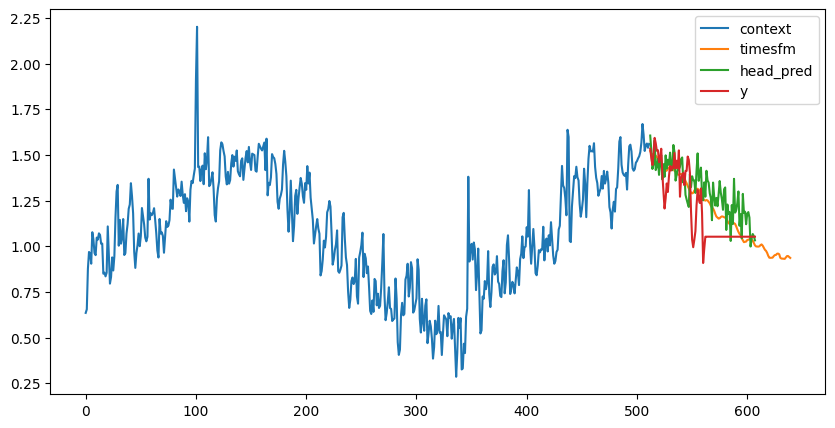

In [59]:
# plt.figure(figsize=(10,5))
# plt.plot(training_loss, label="custom")
# plt.plot(tfm_loss, label="Timesfm")
# plt.legend()
# plt.xlabel("Mini batch")
# plt.ylabel("Median MSE Loss")
# plt.ylim(0, 2000)
# plt.show()


x, y = load_dataset('tsmixup', 100, pred_length=horizon_len, ctx_len=context_len)
tfm_pred, _, (latents, stats) = tfm.forecast(x, get_stacked_transformer=True)
latents = latents[:, -1, :].to(device)

out = pred_head(latents)  # [B, horizon_len * output_dims]
b, _, = out.shape
out = out.view(b, horizon_len)  # [B, H]

mu    = stats[:, 0].float()                                # [B]
sigma = stats[:, 1].float()
head_pred = out * sigma[:, None] + mu[:, None]
tfm_pred, _ = tfm.forecast(x)
ind = 3
plt.figure(figsize=(10,5))
plt.plot(x[ind], label="context")
plt.plot(np.arange(tfm_pred.shape[1]) + context_len, tfm_pred[ind], label='timesfm')
plt.plot(np.arange(head_pred.shape[1]) + context_len, head_pred[ind].detach().cpu(), label='head_pred')
plt.plot(np.arange(y.shape[1]) + context_len, y[ind].detach().cpu(), label='y')
plt.legend()
plt.show()

In [91]:
# Training setup
for batch_num in range(0, tot_iters, batch_size):
    latents, stats, labels = [], [], []
    for i in range(batch_size):
        dataset_ind = batch_num + i
        latent, stat, label = full_ds[dataset_ind]
        latents.append(latent)
        stats.append(stat)
        labels.append(label)
    latents = torch.stack(latents).to(device).float()
    stats   = torch.stack(stats).to(device)
    labels  = torch.stack(labels).to(device)
    if stats.isnan().any():
        print(f"stats is nan")
    if labels.isnan().any():
        print(f"labels is nan")

    optimizer.zero_grad(set_to_none=True)
    out = pred_head(latents)  # [B, N, horizon_len * output_dims]
    b, n, _ = out.shape
    out = out.view(b, n, horizon_len, output_dims)  # [B, N, H, D]

    mu    = stats[:, 0].float()                                # [B]
    sigma = stats[:, 1].float()
    
    mu    = torch.nan_to_num(mu, nan=0.0, posinf=0.0, neginf=0.0)
    sigma = torch.nan_to_num(sigma, nan=1.0, posinf=sigma_ceiling, neginf=sigma_floor)
    sigma = sigma.clamp(min=sigma_floor, max=sigma_ceiling)


    # Predicted mean in original space
    mu_pred = out[..., 0] * sigma[:, None, None] + mu[:, None, None]

    # Predicted log-variance in normalized space (log σ_z^2)
    raw_logvar_norm = out[..., 1]                    # unconstrained
    logvar_norm = raw_logvar_norm.clamp(logvar_min, logvar_max)

    # Move to original space via log add: log(var_y) = log(var_z) + 2*log(sigma)
    log_sigma = torch.log(sigma)
    logvar_pred = logvar_norm + 2.0 * log_sigma[:, None, None]

    # Final clamp in log-space, then exponentiate
    log_var_floor, log_var_ceil = math.log(var_floor), math.log(var_ceiling)
    logvar_pred = logvar_pred.clamp(min=log_var_floor, max=log_var_ceil)
    var_pred = torch.exp(logvar_pred)

    # Extra normalized variance floor (pre sigma) to avoid tiny denominators
    min_var_norm = (min_std_norm ** 2)
    var_pred = torch.maximum(var_pred, (sigma[:, None, None] ** 2) * min_var_norm)

    # Select the last horizon step
    mu_pred  = mu_pred[:, -1]       # [B, H]
    var_pred = var_pred[:, -1]      # [B, H]
    y = labels.float()              # [B, H] (make sure shapes match)

    # GaussianNLLLoss expects (input=mean_pred, target=y, var=variance)
    loss = loss_fn(mu_pred, y, var_pred)

    # Backward with AMP
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    if grad_clip is not None:
        torch.nn.utils.clip_grad_norm_(pred_head.parameters(), grad_clip)
    scaler.step(optimizer)
    scaler.update()

    print(f"isfinite: mu {torch.isfinite(mu).all()}, sigma {torch.isfinite(sigma).all()}, y {torch.isfinite(y).all()}")
    print(f"isfinite: out {torch.isfinite(out).all()}, min {out[...,1].min()} max {out[...,1].max()}")
    print(f"isfinite: mu_pred {torch.isfinite(mu_pred).all()}, min {var_pred.min()} max {var_pred.max()}")
    # Logging
    if batch_num % (batch_size * 1) == 0:
        print(f"batch_num: {batch_num // batch_size} loss: {loss.item():.4f}")
        print(var_pred.min().item(), var_pred.max().item(), torch.isfinite(var_pred).all().item())
        assert torch.isfinite(mu_pred).all() and torch.isfinite(var_pred).all()

isfinite: mu True, sigma True, y True
isfinite: out True, min -7.340322971343994 max 2164.43017578125
isfinite: mu_pred True, min 9.999996707435455e-13 max 434955680.0
batch_num: 0 loss: 0.8890
9.999996707435455e-13 434955680.0 True
isfinite: mu True, sigma True, y True
isfinite: out False, min nan max nan
isfinite: mu_pred True, min 2.8721790570895855e-11 max 290631.40625
batch_num: 1 loss: 2.8205
2.8721790570895855e-11 290631.40625 True
isfinite: mu True, sigma True, y True
isfinite: out True, min -692.7319946289062 max 1904.6378173828125
isfinite: mu_pred True, min 6.651426631698598e-10 max 887117.8125
batch_num: 2 loss: 1.6179
6.651426631698598e-10 887117.8125 True
isfinite: mu True, sigma True, y True
isfinite: out True, min -18.12630271911621 max 609.8141479492188
isfinite: mu_pred True, min 7.148890507346906e-11 max 10521045.0
batch_num: 3 loss: 0.6450
7.148890507346906e-11 10521045.0 True
isfinite: mu True, sigma True, y True
isfinite: out False, min nan max nan
isfinite: mu_pr

AssertionError: 